In [ ]:
# STATUS: WORKS WITH CURRENT PIP AND CONDA ENV
import torch
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, num_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 1000, embed_dim))  # Maximum sequence length = 1000
        self.transformer = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.fc_out = nn.Linear(embed_dim, 1)  # Predict a single value (e.g., next price)
    
    def forward(self, x):
        seq_len = x.size(1)
        x = self.embedding(x) + self.positional_encoding[:, :seq_len, :]
        x = self.transformer(x, x)  # Encoder-only structure
        return self.fc_out(x[:, -1, :])  # Predict based on the last time step

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset

# Custom Dataset Class
class StockDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.sequence_length, :]  # Include all features
        y = self.data[idx + self.sequence_length, 3] # Next close price
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Load and preprocess data
file_path = "cache/WMT_2year_15min_data.csv"
df = pd.read_csv(file_path)
# show the first 5 rows
features = ["open", "high", "low", "close", "volume"]
df = df[features]
print(df.head())
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features].values)
print(scaled_data[:5])

sequence_length = 30
dataset = StockDataset(scaled_data, sequence_length)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    open   high    low  close    volume
0  50.71  50.95  50.67  50.75  893271.0
1  50.75  50.82  50.67  50.70  538911.0
2  50.71  50.77  50.62  50.65  322002.0
3  50.65  50.79  50.64  50.69  346329.0
4  50.69  50.74  50.66  50.66  362862.0
[[-0.71488061 -0.69815288 -0.71311288 -0.71116958  1.11030799]
 [-0.71120199 -0.71009227 -0.71311288 -0.71576715  0.31207216]
 [-0.71488061 -0.71468434 -0.71771779 -0.72036472 -0.1765398 ]
 [-0.72039853 -0.71284751 -0.71587583 -0.71668666 -0.12174049]
 [-0.71671991 -0.71743958 -0.71403386 -0.7194452  -0.08449804]]


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


# Model Hyperparameters
input_dim = len(features)  # Number of input features
embed_dim = 64
num_heads = 4
ff_dim = 256
num_layers = 4
learning_rate = 0.001

# Initialize Model, Loss, Optimizer
model = TimeSeriesTransformer(input_dim, embed_dim, num_heads, ff_dim, num_layers)
criterion = nn.MSELoss()

# Training Loop
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)  # Halve LR every 10 epochs

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in dataloader:
        optimizer.zero_grad()
        predictions = model(x)
        loss = criterion(predictions.squeeze(), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader)}")
    
    # Step the scheduler
    scheduler.step()

Mean Absolute Error (MAE): 3.473531169758394
Mean Squared Error (MSE): 13.227091815220447
Root Mean Squared Error (RMSE): 3.6369069021931875
Mean Absolute Percentage Error (MAPE): 8.14%
R² Score: -11.40406541944081


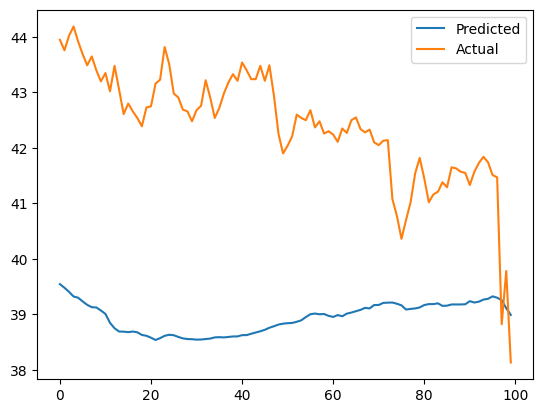

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model.eval()
test_data = scaled_data[-(sequence_length + 100):]

test_dataset = StockDataset(test_data, sequence_length)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

predictions, actuals = [], []
with torch.no_grad():
    for x, y in test_loader:
        pred = model(x)
        predictions.append(pred.item())
        actuals.append(y.item())
# Reverse scaling for visualization
predictions = scaler.inverse_transform([[0, 0, 0, pred, 0] for pred in predictions])[:, 3]
actuals = scaler.inverse_transform([[0, 0, 0, act, 0] for act in actuals])[:, 3]

# Calculate metrics
test_loss = criterion(torch.tensor(predictions), torch.tensor(actuals)).item()
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = mse ** 0.5
mape = 100 * (np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))))
r2 = r2_score(actuals, predictions)

# Print results
print(f"Test Loss: {test_loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2}")

# Plot predictions vs actuals
plt.plot(predictions, label="Predicted")
plt.plot(actuals, label="Actual")
plt.legend()
plt.show()

In [ ]:
from itertools import product

# Define hyperparameter search space
param_grid = {
    "embed_dim": [64, 128],
    "num_heads": [4, 8],
    "ff_dim": [256, 512],
    "num_layers": [3, 4],
    "learning_rate": [0.001, 0.0005],
}

# Generate all combinations of hyperparameters
param_combinations = list(product(*param_grid.values()))

best_loss = float("inf")
best_params = None

for params in param_combinations:
    embed_dim, num_heads, ff_dim, num_layers, learning_rate = params

    # Initialize model
    model = TimeSeriesTransformer(input_dim=5, embed_dim=embed_dim, num_heads=num_heads,
                                   ff_dim=ff_dim, num_layers=num_layers)
    
    # Optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)  # Halve LR every 10 epochs
    criterion = nn.MSELoss()

    # Training loop (simplified)
    for epoch in range(5):  # Use a small number of epochs for testing
        model.train()
        total_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            predictions = model(x)
            loss = criterion(predictions.squeeze(), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        scheduler.step()
      
    # Evaluate loss
    avg_loss = total_loss / len(dataloader)
    print(f"Params: {params}, Training Loss: {avg_loss}")
    

    # evaluate loss on test data
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for x, y in test_loader:
            pred = model(x)
            predictions.append(pred.item())
            actuals.append(y.item())
    test_loss = criterion(torch.tensor(predictions), torch.tensor(actuals)).item()
    print(f"Params: {params}, Test Loss: {test_loss}")
    if test_loss < best_loss:
        best_loss = test_loss
        best_params = params
    
    

print(f"Best Parameters: {best_params}, Best Loss: {best_loss}")

Params: (64, 4, 256, 3, 0.001), Training Loss: 0.007442898557434235
Params: (64, 4, 256, 3, 0.001), Test Loss: 0.0062572043389081955
Params: (64, 4, 256, 3, 0.0005), Training Loss: 0.007355708349037347
Params: (64, 4, 256, 3, 0.0005), Test Loss: 0.005004091653972864
Params: (64, 4, 256, 4, 0.001), Training Loss: 0.007651900940258148
Params: (64, 4, 256, 4, 0.001), Test Loss: 0.0014803324593231082
Params: (64, 4, 256, 4, 0.0005), Training Loss: 0.008427107970464259
Params: (64, 4, 256, 4, 0.0005), Test Loss: 0.03547000512480736
Params: (64, 4, 512, 3, 0.001), Training Loss: 0.007749882616157749
Params: (64, 4, 512, 3, 0.001), Test Loss: 0.04596564918756485
Params: (64, 4, 512, 3, 0.0005), Training Loss: 0.008032336753100304
Params: (64, 4, 512, 3, 0.0005), Test Loss: 0.0029262304306030273
Params: (64, 4, 512, 4, 0.001), Training Loss: 0.00596719461360148
Params: (64, 4, 512, 4, 0.001), Test Loss: 0.03758159279823303
Params: (64, 4, 512, 4, 0.0005), Training Loss: 0.0076968404074461
Para